_Version log: Branch of V19. Parameter scan accross number of pixels._

In [9]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import fft as spfft, interpolate as spinter
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [10]:
#########FUNCTIONS INCLUDING COMPRESSED SENSING###########

def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
        if array.ndim == 2:
            return array.T
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward")

    return result


def subsample_1d(total_points, reduced_points, subsampling_method = "random"):

    if subsampling_method == "random":
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

def interpolate(y, new_number_of_points):
    x = range(len(y))
    new_x = np.linspace(0, len(y) -1, new_number_of_points, endpoint= True)
    inter = spinter.interp1d(x, y, bounds_error= False, fill_value= "extrapolate")
    return inter(new_x)

In [11]:
def simulated_annealling(target, detectors, regularization_coeffient, min_seperation= 1, uncertainties= 1, iterations= 5000, max_temp= 31, cooling= 0.995):

    #########INITAILISATION##########
    total_points = len(target)
    reduced_points = len(detectors)
    result = compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)
    score = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared
    target_temp = max_temp
    improvement = True

    #######START SIMULATED ANNEALLING###########
    for n in range(iterations):
        t = round(target_temp) #reset steps
        new_detectors = np.copy(detectors) #reset detectors
        new_score = np.copy(score) #reset score

        while t > 0:
            random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points
            current = new_detectors[random_detector]
            previous = -1 if random_detector == 0 else new_detectors[random_detector -1] #consider making the end points fixed. It helps define the length of the detector array.
            next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]
            if previous +min_seperation < current and current < next -min_seperation:
                #detector has space to move forward or back.
                new_detectors[random_detector] += np.random.choice([-1,1])
                t -= 1
            elif previous +min_seperation < current:
                #detector has space to move back.
                new_detectors[random_detector] -= 1
                t -= 1
            elif current < next -min_seperation:
                #detector has space to move forward.
                new_detectors[random_detector] += 1
                t -= 1
            else:
                #detector can't move.
                pass

        new_result = compressed_sensing(target[new_detectors], new_detectors, total_points, regularization_coeffient)
        new_score = np.linalg.norm((target -new_result) /uncertainties) #This is the chi-squared

        if new_score < score:
            detectors = new_detectors
            result = new_result
            score = new_score
            improvement = True

        if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
            target_temp = max_temp
            improvement = False
        elif improvement: #When hot, stop exploring and start optimising this regime.
            target_temp *= cooling

    return detectors, score

In [12]:
file_number = 2
file_name = "1dmockanderrors{:d}".format(file_number)
file_type = ".csv"
total_point = 400
reduced_point = 8
regularization_coeffient = 1e-4 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

In [13]:
#LOOP INITIALISATION

total_points = [400]
total_points = np.repeat(total_points, 1)

dataset = open_dataset(file_name, file_type)
best_scores = np.array([])

optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [14]:
###################### THIS WILL TAKE A LONG TIME!!! (approx 1 min per iteration) #################

for total_point in tqdm(total_points):

    compression = total_point /dataset.shape[1]
    target = interpolate(dataset[0], total_point)
    uncertainties = interpolate(dataset[1], total_point)
    detectors = subsample_1d(total_point, reduced_point, "random")

    detectors, score = simulated_annealling(target, detectors, regularization_coeffient, uncertainties= uncertainties, iterations= 5000, max_temp= 31, cooling= 0.998)

    best_scores = np.append(best_scores, score)

    with open(optlocs_file, 'a') as file:
        equivalent_locations = np.round(detectors/compression).astype(int)
        detectors_string = np.array2string(equivalent_locations, separator=',').replace('\n', '')[1:-1]
        file.write(detectors_string +"\n")
        file.close()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:41<00:00, 101.58s/it]


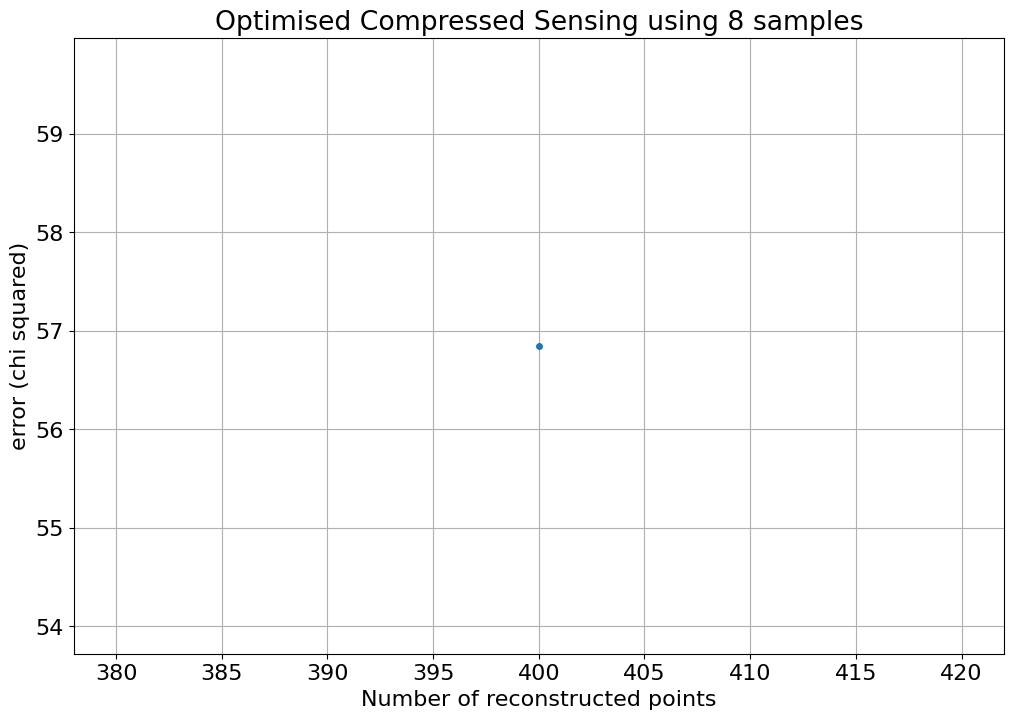

In [15]:
fig, axs = plt.subplots(figsize= (12,8))

axs.plot(np.round(total_points), best_scores, linestyle= "None", marker= ".", markersize= 8)
axs.set(xlabel= "Number of reconstructed points",
        ylabel= "error (chi squared)",
        title= "Optimised Compressed Sensing using {0:d} samples".format(reduced_point))
        #xticks= np.round(np.unique(subsample_percentages)[::2] *total_point),
        #xlim= (0, total_point),
        #yscale= "log",
        #yticks= [2,5,10,20,50,100])

#axs.get_yaxis().set_major_formatter(ticker.ScalarFormatter()) #allows custom ticks in logscale
axs.grid(True)

plt.show()

In [16]:
#array = np.array([np.round(subsample_percentages *total_point), best_scores]).T
#np.savetxt("data\\error2samples{:d}.csv".format(file_number), array, delimiter=',', header="no of samples, error")